# Genetic Algorihm for UPC&S

## Import packages

In [99]:
import random
from numpy.random import randint
from numpy.random import rand
import pandas as pd
import datetime
import numpy as np
from tqdm import tqdm
pd.set_option('display.max_row', 100)


## Read Data & Assign the variables

In [44]:
# read data
df_sample = pd.read_csv('sample2.csv')

# assign the variables

cost = df_sample[['item', 'T', 'C']].drop_duplicates().dropna(axis=0)
demand = df_sample[['item', 'T', 'D']].drop_duplicates().dropna(axis=0)
prepaid = df_sample[['item', 'T', 'P']].drop_duplicates().dropna(axis=0)
cycle = df_sample[['item', 'J', 'T', 'M']].drop_duplicates().dropna(axis=0)

cost1 = cost.dropna(axis=0)
demand1 = demand.dropna(axis=0)
prepaid1 = prepaid.dropna(axis=0)
cycle1 = cycle.dropna(axis=0)


ijt_df = pd.DataFrame(df_sample[['item', 'J', 'T']].value_counts()).reset_index()[['item', 'J', 'T']]
ijt_df = ijt_df.sort_values(['item']).reset_index(drop=True)
ijt_set = set()
for index, info in ijt_df.iterrows():
    ijt_set.add((info['item'], info['J'], info['T']))
ijt_set

# variables infomation
T = list(set(df_sample['T']))
I = list(set(df_sample['item']))
J = list(set(df_sample['J']))

# Parameters
cit = {}
pit = {}
dit = {}
mijt = {}

# cit - 단가
for index, info in cost.iterrows():
    cit[info['item'], info['T']] = info['C']
# pit - 선급품/일반품
for index, info in prepaid.iterrows():
    pit[info['item'], info['T']] = info['P']
# dit - 생산목표량
for index, info in demand.iterrows():
    dit[info['item'], info['T']] = info['D']
# mijt - cycle time
for index, info in cycle.iterrows():
    mijt[info['item'], info['J'], info['T']] = info['M']

# adding missing values
for i in I:
    for t in T:
        key = (i, t)
        if key not in cit:
            cit[i, t] = 0
for i in I:
    for t in T:
        key = (i, t)
        if key not in pit:
            pit[i, t] = 0
for i in I:
    for t in T:
        key = (i, t)
        if key not in dit:
            dit[i, t] = 0
for i in I:
    for j in J:
        for t in T:
            key = (i, j, t)
            if key not in mijt:
                mijt[i, j, t] = 0

In [45]:
# file read
df_raw = pd.read_excel('생산미결리스트 등 샘플데이터.xlsx', sheet_name=None)
machine_info = df_raw['CYCLETIME'][1:].reset_index(drop=True)
order_info = df_raw['생산미결리스트(for cost)'].reset_index(drop=True)

# 전처리 (1) coulmn name 변경
order_info = order_info.rename(columns={
    '영업납기':'date',
    '중산도면': 'item',
    '단가': 'cost',
    '수량' :'qty',
    '선급': 'urgent'
})
order_info = order_info[['date', 'item', 'cost', 'qty', 'urgent']]

machine_info = machine_info.rename(columns={
    'JSDWG':'item',
    'MCNO':'machine',
    'AVG_CT': 'capacity' 
})
machine_info = machine_info[['item', 'machine', 'capacity']]


# 전처리 (2) 분석을 위한 데이터 처리
order_info['urgent'] = order_info['urgent'].fillna(0)
for i in range(len(order_info)):
    if order_info.loc[i, 'urgent']!=0:
        order_info.loc[i, 'urgent'] = 1



In [46]:
order_info.head()

,date,item,cost,qty,urgent
0,2021-05-13,K04033,25870,318,1
1,2021-05-24,K04031,16229,383,1
2,2021-05-30,069622,5409,20,0
3,2021-05-30,051718,8333,19,0
4,2021-06-03,056984,36533,4,0


In [47]:
order_info.value_counts()

date        item    cost    qty  urgent
2021-02-10  S00341  2990    500  0         1
2021-07-02  066736  11500   42   0         1
            069159  481190  52   1         1
            069196  10220   80   0         1
            070283  61010   14   1         1
                                          ..
2021-06-18  Z01343  16231   8    0         1
2021-06-21  062716  27590   120  1         1
            062953  23500   160  1         1
            072253  15000   20   1         1
2021-10-08  071028  71000   128  1         1
Length: 183, dtype: int64

In [48]:
machine_info.head()

,item,machine,capacity
0,050060,0433,1.08
1,050093,0404,7.13
2,050093,0408,4.67
3,050093,0410,4.5
4,050093,0416,3.92


In [49]:
machine_info.value_counts()

item    machine  capacity
050060  0433     1.08        1
K00347  0404     11.05       1
K00337  0438     40.00       1
        0437     7.13        1
        0410     8.77        1
                            ..
058398  0408     4.61        1
        0404     4.17        1
058396  0438     7.08        1
        0434     6.30        1
Z01415  0409     9.50        1
Length: 21149, dtype: int64

# 데이터 유효성 검사

In [50]:
# 1. 완전성 (Completeness)
perc = 30
df_set = {'order_info':order_info, 'machine_info':machine_info}
for df_name in list(df_set):
    print(f'DataFrame name: {df_name}')
    df = df_set[df_name]
    print('[step 1-1]')
    print(round(df.isnull().sum()/len(df)*100, 2))
    print('[step 1-2]')
    print(df.isnull().sum()/len(df)*100>perc)
    print('[step 2-1]')
    print(df.isnull().head())
    print('[step 2-2]')
    print(df.isnull().sum())
    print('[step 2-3]')
    cmpt_len = df.isnull().sum().sum()
    print(cmpt_len)


print("결측치 = %d개 \n완전성 지수 : %.2f%% "%(cmpt_len,(1-cmpt_len/len(df))*100))

DataFrame name: order_info
[step 1-1]
date      0.0
item      0.0
cost      0.0
qty       0.0
urgent    0.0
dtype: float64
[step 1-2]
date      False
item      False
cost      False
qty       False
urgent    False
dtype: bool
[step 2-1]
    date   item   cost    qty  urgent
0  False  False  False  False   False
1  False  False  False  False   False
2  False  False  False  False   False
3  False  False  False  False   False
4  False  False  False  False   False
[step 2-2]
date      0
item      0
cost      0
qty       0
urgent    0
dtype: int64
[step 2-3]
0
DataFrame name: machine_info
[step 1-1]
item        0.00
machine     0.01
capacity    0.00
dtype: float64
[step 1-2]
item        False
machine     False
capacity    False
dtype: bool
[step 2-1]
    item  machine  capacity
0  False    False     False
1  False    False     False
2  False    False     False
3  False    False     False
4  False    False     False
[step 2-2]
item        0
machine     2
capacity    0
dtype: int64
[step 2-3]

In [51]:
# 2. 유일성 (Uniqueness)

check_unique = order_info[
    ['date', 'item', 'urgent']
    ].value_counts().reset_index()
perc_check_unique_item_urgent_info = round(
    (len(check_unique)-len(check_unique[check_unique[0]>1]))
    /len(check_unique)*100, 2)

check_unique = machine_info[
    ['item', 'machine']
    ].value_counts().reset_index()
perc_check_unique_machine_info = round(
    (len(check_unique)-len(check_unique[check_unique[0]>1]))
    /len(check_unique)*100, 2)

print(f'The percentage of uniqueness for date<->item<->cost<->urgent : {perc_check_unique_item_urgent_info}')
print(f'The percentage of uniqueness for item<->machine : {perc_check_unique_machine_info}')
print("유일성 지수 : %.2f%% "%((perc_check_unique_machine_info+perc_check_unique_item_urgent_info)/2))

The percentage of uniqueness for date<->item<->cost<->urgent : 98.33
The percentage of uniqueness for item<->machine : 100.0
유일성 지수 : 99.16% 


In [52]:
check_unique = order_info[
    ['date', 'item', 'urgent']
    ].value_counts().reset_index()
check_unique

,date,item,urgent,0
0,2021-06-15,K03115,0,2
1,2021-07-09,057387,1,2
2,2021-07-09,057386,1,2
3,2021-02-10,S00341,0,1
4,2021-07-06,059988,1,1
...,...,...,...,...
175,2021-06-18,Z01343,0,1
176,2021-06-21,062716,1,1
177,2021-06-21,062953,1,1
178,2021-06-21,072253,1,1


In [53]:
check_unique = machine_info[
    ['item', 'machine']
    ].value_counts().reset_index()
check_unique

,item,machine,0
0,050060,0433,1
1,K00347,0404,1
2,K00337,0438,1
3,K00337,0437,1
4,K00337,0410,1
...,...,...,...
21144,058398,0408,1
21145,058398,0404,1
21146,058396,0438,1
21147,058396,0434,1


In [54]:
perc_check_unique_item_urgent_info = round(
    (len(check_unique)-len(check_unique[check_unique[0]>1]))
    /len(check_unique)*100, 2)
print(f'The percentage of uniqueness for date<->item<->cost<->urgent : {perc_check_unique_item_urgent_info}')


The percentage of uniqueness for date<->item<->cost<->urgent : 100.0


In [55]:
cit

{('K04033', 1): 25870,
 ('K04031', 1): 16229,
 ('K04037', 2): 7810,
 ('K04046', 2): 9416,
 ('K04101', 3): 15640,
 ('K61088', 3): 11500,
 ('K62716', 4): 27590,
 ('K61606', 4): 14448,
 ('K62330', 5): 13099,
 ('K61218', 5): 35100,
 ('K57386', 6): 22750,
 ('K57791', 6): 42810,
 ('K61218', 1): 0,
 ('K61218', 2): 0,
 ('K61218', 3): 0,
 ('K61218', 4): 0,
 ('K61218', 6): 0,
 ('K62716', 1): 0,
 ('K62716', 2): 0,
 ('K62716', 3): 0,
 ('K62716', 5): 0,
 ('K62716', 6): 0,
 ('K04031', 2): 0,
 ('K04031', 3): 0,
 ('K04031', 4): 0,
 ('K04031', 5): 0,
 ('K04031', 6): 0,
 ('K57386', 1): 0,
 ('K57386', 2): 0,
 ('K57386', 3): 0,
 ('K57386', 4): 0,
 ('K57386', 5): 0,
 ('K61088', 1): 0,
 ('K61088', 2): 0,
 ('K61088', 4): 0,
 ('K61088', 5): 0,
 ('K61088', 6): 0,
 ('K04037', 1): 0,
 ('K04037', 3): 0,
 ('K04037', 4): 0,
 ('K04037', 5): 0,
 ('K04037', 6): 0,
 ('K04101', 1): 0,
 ('K04101', 2): 0,
 ('K04101', 4): 0,
 ('K04101', 5): 0,
 ('K04101', 6): 0,
 ('K61606', 1): 0,
 ('K61606', 2): 0,
 ('K61606', 3): 0,
 ('K

In [56]:
# 3. 유효성 (Validity)

print('order_info case')
df = order_info
c_lb = df['cost'] >= 0
c_ub = df['cost'] <= 1000000
q_lb = df['qty'] >= 0
q_ub = df['qty'] <= 1000000
u_lb = df['urgent'] >= 0
u_ub = df['urgent'] <= 1
vald_df = df[c_lb & c_ub & q_lb & q_ub & u_lb & u_ub]
print(f'[Step 1] 데이터 범위를 벗어난 데이터 수: {len(df) - len(vald_df)}')

d0 = pd.Timestamp(datetime.date(2021,1,31))  #date 객체1
d1 = pd.Timestamp(datetime.date(2021,10,31))  #date 객체2
con1 = vald_df['date'] >= d0
con2 = vald_df['date'] <= d1
vald_df = vald_df[con1&con2]
print(f'[Step 2] 수집된 날짜를 벗어나는 데이터 수: {len(df) - len(vald_df)}')

vald_df['date'] = vald_df['date'].apply(lambda x: isinstance(x, datetime.datetime))
vald_df['item'] = vald_df['item'].apply(lambda x: isinstance(x, str))
vald_df['cost'] = vald_df['cost'].apply(lambda x: isinstance(x, int))
vald_df['qty'] = vald_df['qty'].apply(lambda x: isinstance(x, int))
vald_df['urgent'] = vald_df['urgent'].apply(lambda x: isinstance(x, int))
print(f'[Step 3] 데이터 형식을 벗어나는 데이터 수: {len(df) - len(vald_df)}')

vald_df[
    (vald_df['date']==True)
    &(vald_df['item']==True)
    &(vald_df['cost']==True)
    &(vald_df['qty']==True)
    &(vald_df['urgent']==True)
    ]
vald_len = len(vald_df)
item_vald = vald_len/len(df)*100
print("order_info 유효성 지수 : %.2f%% "%(item_vald)) 

print('machine_info case')
df = machine_info
cap_lb = df['capacity'] >= 0
cap_ub = df['capacity'] <= 1000000
vald_df = df[cap_ub & cap_lb]
print(f'[Step 1] 데이터 범위를 벗어난 데이터 수: {len(df) - len(vald_df)}')

vald_df['item'] = vald_df['item'].apply(lambda x: isinstance(x, str))
vald_df['machine'] = vald_df['machine'].apply(lambda x: isinstance(x, str))
vald_df['capacity'] = vald_df['capacity'].apply(lambda x: float(x) if isinstance(x, int)==True else x)
vald_df['capacity'] = vald_df['capacity'].apply(lambda x: isinstance(x, float))
print(f'[Step 3] 데이터 형식을 벗어나는 데이터 수: {len(df) - len(vald_df)}')

vald_df[
    (vald_df['item']==True)
    &(vald_df['machine']==True)
    &(vald_df['capacity']==True)
    ]
vald_len = len(vald_df)
machine_vald = vald_len/len(df)*100
print("machine_info 유효성 지수 : %.2f%% "%(machine_vald)) 

print("유효성 지수 : %.2f%% "%((item_vald + machine_vald)/2)) 


order_info case
[Step 1] 데이터 범위를 벗어난 데이터 수: 0
[Step 2] 수집된 날짜를 벗어나는 데이터 수: 0
[Step 3] 데이터 형식을 벗어나는 데이터 수: 0
order_info 유효성 지수 : 100.00% 
machine_info case
[Step 1] 데이터 범위를 벗어난 데이터 수: 0
[Step 3] 데이터 형식을 벗어나는 데이터 수: 0
machine_info 유효성 지수 : 100.00% 
유효성 지수 : 100.00% 


In [57]:
# 데이터 형식 확인
print('[Step 2] 데이터 형식을 벗어나는 데이터 수')
check_validity = []
check = len(order_info) - sum(order_info['date'].apply(lambda x: isinstance(x, datetime.datetime)))
check_validity.append(['order_info | date (datetime)', check])
check = len(order_info) - sum(order_info['item'].apply(lambda x: isinstance(x, str)))
check_validity.append(['order_info | item (str)', check])
check = len(order_info) - sum(order_info['cost'].apply(lambda x: isinstance(x, int)))
check_validity.append(['order_info | cost (int)', check])
check = len(order_info) - sum(order_info['qty'].apply(lambda x: isinstance(x, int)))
check_validity.append(['order_info | qty (int)', check])
check = len(order_info) - sum(order_info['urgent'].apply(lambda x: isinstance(x, int)))
check_validity.append(['order_info | urgent (int)', check])

check = round(
    ( len(machine_info)- sum(machine_info['item'].apply(lambda x: isinstance(x, str))
    ))/len(machine_info)*100, 3)
check_validity.append(['machine_info | item (str)', check])
check = round(
    (len(machine_info) - sum(machine_info['machine'].apply(lambda x: isinstance(x, str))
    ))/len(machine_info)*100, 3)
check_validity.append(['machine_info | machine (str)', check])
check = 0
for i in machine_info['capacity']:
    if isinstance(i, float):
        if isinstance(i, int):
            check += 0
check_validity.append(['machine_info | capacity (float)', round(check/len(machine_info)*100,3)])

pd.DataFrame(check_validity)




[Step 2] 데이터 형식을 벗어나는 데이터 수


,0,1
0,order_info | date (datetime),0.000
1,order_info | item (str),0.000
2,order_info | cost (int),0.000
3,order_info | qty (int),0.000
4,order_info | urgent (int),0.000
5,machine_info | item (str),0.000
6,machine_info | machine (str),0.009
7,machine_info | capacity (float),0.000


In [58]:
# 4. 일관성 
df = order_info
vald_df = df[['item']].copy()
vald_df['check'] = vald_df['item'].isin(set(machine_info['item']))
print("일관성 지수 : %.2f%% "%(sum(vald_df['check'])/len(df)*100)) 
vald_df


일관성 지수 : 69.40% 


,item,check
0,K04033,True
1,K04031,True
2,069622,False
3,051718,True
4,056984,True
...,...,...
178,070541,False
179,K04037,True
180,071028,False
181,Z00807,True


In [59]:
machine_info

,item,machine,capacity
0,050060,0433,1.08
1,050093,0404,7.13
2,050093,0408,4.67
3,050093,0410,4.5
4,050093,0416,3.92
...,...,...,...
21146,Z01387,0439,2.32
21147,Z01387,0440,2.34
21148,Z01388,0433,4.16
21149,Z01407,0408,3


# 전처리



In [60]:
# nan값 처리
n_before_preprocess = len(machine_info)
machine_info.dropna(axis=0, inplace=True)
n_after_preprocess = len(machine_info)
print(f'Machine_info : nan 값 제거 ({n_before_preprocess} row --> {n_after_preprocess} row, {round(((n_before_preprocess-n_after_preprocess)/n_before_preprocess*100), 3)}% 삭제)')

n_before_preprocess = len(order_info)
order_info = order_info[['date', 'item', 'cost', 'qty', 'urgent']]
order_info.dropna(axis=0, inplace=True)
n_after_preprocess = len(order_info)
print(f'order_info : nan 값 제거 ({n_before_preprocess} row --> {n_after_preprocess} row, {round(((n_before_preprocess-n_after_preprocess)/n_before_preprocess*100), 3)}% 삭제)')


Machine_info : nan 값 제거 (21151 row --> 21149 row, 0.009% 삭제)
order_info : nan 값 제거 (183 row --> 183 row, 0.0% 삭제)


In [61]:
order_info[['date', 'item', 'cost']].value_counts().head()


date        item    cost  
2021-06-15  K03115  26719     2
2021-07-09  057387  17794     2
            057386  24418     2
2021-02-10  S00341  2990      1
2021-07-06  059988  166250    1
dtype: int64

In [62]:
# unique 처리
machine_info[['item', 'machine']].value_counts().head() # 모두 unique하므로 바로 사용

item    machine
050060  0433       1
K00347  0404       1
K00337  0438       1
        0437       1
        0410       1
dtype: int64

In [63]:

order_info[['date', 'item', 'cost', 'urgent']].value_counts().head()


date        item    cost    urgent
2021-06-15  K03115  26719   0         2
2021-07-09  057387  17794   1         2
            057386  24418   1         2
2021-02-10  S00341  2990    0         1
2021-07-06  059988  166250  1         1
dtype: int64

In [64]:
order_info[(order_info['date']=='2021-06-15')&(order_info['item']=='K03115')]

,date,item,cost,qty,urgent
40,2021-06-15,K03115,26719,30,0
42,2021-06-15,K03115,26719,28,0


In [65]:
order_info = order_info.groupby(['date', 'item', 'cost', 'urgent']).sum().reset_index()
order_info[['date', 'item']].value_counts().head()


date        item  
2021-02-10  S00341    1
2021-07-02  057791    1
            068898    1
            069159    1
            069196    1
dtype: int64

In [66]:
order_info[(order_info['date']=='2021-06-15')&(order_info['item']=='K03115')]

,date,item,cost,urgent,qty
43,2021-06-15,K03115,26719,0,58


In [67]:
order_info.describe()

,cost,urgent,qty
count,180.000000,180.000000,180.000000
mean,44470.766667,0.400000,103.011111
std,73356.131743,0.491264,128.748770
min,1213.000000,0.000000,1.000000
25%,11500.000000,0.000000,16.000000
50%,21310.000000,0.000000,44.000000
75%,39110.000000,1.000000,152.500000
max,481190.000000,1.000000,716.000000


In [68]:
machine_info.describe()

,item,machine,capacity
count,21149,21149,21149.0
unique,6617,37,2835.0
top,K04673,0424,2.0
freq,20,1953,364.0


In [69]:

date_start = [
    '2021-01-01',
    '2021-02-01',
    '2021-03-01',
    '2021-04-01',
    '2021-05-01',
    '2021-06-01',
    '2021-07-01',
    '2021-08-01',
    '2021-09-01',    
]
for i in range(len(date_start)-1):
    check_df = order_info[
        (order_info['date'] >date_start[i])
        &(order_info['date'] <date_start[i+1])
        ]
    print(f'{date_start[i]} ~ {date_start[i+1]}생산 주문 건 수: {len(check_df)}')



2021-01-01 ~ 2021-02-01생산 주문 건 수: 0
2021-02-01 ~ 2021-03-01생산 주문 건 수: 2
2021-03-01 ~ 2021-04-01생산 주문 건 수: 1
2021-04-01 ~ 2021-05-01생산 주문 건 수: 1
2021-05-01 ~ 2021-06-01생산 주문 건 수: 10
2021-06-01 ~ 2021-07-01생산 주문 건 수: 88
2021-07-01 ~ 2021-08-01생산 주문 건 수: 58
2021-08-01 ~ 2021-09-01생산 주문 건 수: 6


In [70]:
# 7월 주문 해보기
filtered_order_info = order_info[
    (order_info['date'] > '2021-01-01')
    &(order_info['date'] < '2021-06-01')
    ]

filtered_order_info

,date,item,cost,urgent,qty
0,2021-02-10,S00341,2990,0,500
1,2021-02-18,052996,20000,0,2
2,2021-03-10,S00341,2990,0,500
3,2021-04-10,S00341,2990,0,500
4,2021-05-10,S00341,2990,0,398
5,2021-05-13,066157,18500,1,208
6,2021-05-13,K04033,25870,1,318
7,2021-05-24,K04031,16229,1,383
8,2021-05-30,051718,8333,0,19
9,2021-05-30,052996,20000,0,2


In [71]:
dataset = pd.merge(filtered_order_info, machine_info, on='item', how='inner')
dataset.to_csv('dataset.csv', index=False)


In [72]:
dataset = pd.read_csv('dataset.csv')
##
# MIP
ijt_df = pd.DataFrame(dataset[['item', 'machine', 'date']].value_counts()).reset_index()[['item', 'machine', 'date']]
ijt_df=ijt_df.sort_values(['item']).reset_index(drop=True)
ijt_set = set()
for index, info in ijt_df.iterrows():
    ijt_set.add((info['item'], info['machine'], info['date']))


# variables infomation
T = list(set(dataset['date']))
I = list(set(dataset['item']))
J = list(set(dataset['machine']))



In [73]:
T

['2021-04-10',
 '2021-02-18',
 '2021-05-31',
 '2021-02-10',
 '2021-05-13',
 '2021-05-30',
 '2021-03-10',
 '2021-05-24',
 '2021-05-10']

In [74]:
I

['K04031',
 '066157',
 '052996',
 'S00271',
 'K04033',
 'K04101',
 'S00341',
 '051718']

In [75]:
J

[404,
 405,
 407,
 408,
 409,
 410,
 412,
 416,
 421,
 422,
 424,
 425,
 426,
 433,
 434,
 435,
 436,
 438,
 439,
 440]

In [76]:
cit = dict()
for i in I:
    for t in T:
        temp_dataset = dataset[
            (dataset['item']==i)
            &(dataset['date']==t)]

        if len(temp_dataset) != 0:
            value = list(set(temp_dataset['cost']))[0]
            cit[i, t] = value
        else: 
            cit[i, t] = 0
pit = dict()
for i in I:
    for t in T:
        temp_dataset = dataset[
            (dataset['item']==i)
            &(dataset['date']==t)]
            
        if len(temp_dataset) != 0:
            value = list(set(temp_dataset['urgent']))[0]
            pit[i, t] = value
        else: 
            pit[i, t] = 0

dit = dict()
for i in I:
    for t in T:
        temp_dataset = dataset[
            (dataset['item']==i)
            &(dataset['date']==t)]
            
        if len(temp_dataset) != 0:
            value = list(set(temp_dataset['qty']))[0]
            dit[i, t] = value
        else: 
            dit[i, t] = 0

mijt = dict()
for i in I:
    for j in J:
        temp_dataset = dataset[
            (dataset['item']==i)
            &(dataset['machine']==j)]
            
        if len(temp_dataset) != 0:
            value = list(set(temp_dataset['capacity']))[0]
            for t in T:
                mijt[i, j, t] = value
        else: 
            for t in T:
                mijt[i, j, t] = 0


In [77]:
cit

{('K04031', '2021-04-10'): 0,
 ('K04031', '2021-02-18'): 0,
 ('K04031', '2021-05-31'): 0,
 ('K04031', '2021-02-10'): 0,
 ('K04031', '2021-05-13'): 0,
 ('K04031', '2021-05-30'): 0,
 ('K04031', '2021-03-10'): 0,
 ('K04031', '2021-05-24'): 16229,
 ('K04031', '2021-05-10'): 0,
 ('066157', '2021-04-10'): 0,
 ('066157', '2021-02-18'): 0,
 ('066157', '2021-05-31'): 0,
 ('066157', '2021-02-10'): 0,
 ('066157', '2021-05-13'): 18500,
 ('066157', '2021-05-30'): 0,
 ('066157', '2021-03-10'): 0,
 ('066157', '2021-05-24'): 0,
 ('066157', '2021-05-10'): 0,
 ('052996', '2021-04-10'): 0,
 ('052996', '2021-02-18'): 20000,
 ('052996', '2021-05-31'): 0,
 ('052996', '2021-02-10'): 0,
 ('052996', '2021-05-13'): 0,
 ('052996', '2021-05-30'): 20000,
 ('052996', '2021-03-10'): 0,
 ('052996', '2021-05-24'): 0,
 ('052996', '2021-05-10'): 0,
 ('S00271', '2021-04-10'): 0,
 ('S00271', '2021-02-18'): 0,
 ('S00271', '2021-05-31'): 4000,
 ('S00271', '2021-02-10'): 0,
 ('S00271', '2021-05-13'): 0,
 ('S00271', '2021-05-

In [78]:
pit

{('K04031', '2021-04-10'): 0,
 ('K04031', '2021-02-18'): 0,
 ('K04031', '2021-05-31'): 0,
 ('K04031', '2021-02-10'): 0,
 ('K04031', '2021-05-13'): 0,
 ('K04031', '2021-05-30'): 0,
 ('K04031', '2021-03-10'): 0,
 ('K04031', '2021-05-24'): 1,
 ('K04031', '2021-05-10'): 0,
 ('066157', '2021-04-10'): 0,
 ('066157', '2021-02-18'): 0,
 ('066157', '2021-05-31'): 0,
 ('066157', '2021-02-10'): 0,
 ('066157', '2021-05-13'): 1,
 ('066157', '2021-05-30'): 0,
 ('066157', '2021-03-10'): 0,
 ('066157', '2021-05-24'): 0,
 ('066157', '2021-05-10'): 0,
 ('052996', '2021-04-10'): 0,
 ('052996', '2021-02-18'): 0,
 ('052996', '2021-05-31'): 0,
 ('052996', '2021-02-10'): 0,
 ('052996', '2021-05-13'): 0,
 ('052996', '2021-05-30'): 0,
 ('052996', '2021-03-10'): 0,
 ('052996', '2021-05-24'): 0,
 ('052996', '2021-05-10'): 0,
 ('S00271', '2021-04-10'): 0,
 ('S00271', '2021-02-18'): 0,
 ('S00271', '2021-05-31'): 0,
 ('S00271', '2021-02-10'): 0,
 ('S00271', '2021-05-13'): 0,
 ('S00271', '2021-05-30'): 0,
 ('S00271'

In [79]:
dit

{('K04031', '2021-04-10'): 0,
 ('K04031', '2021-02-18'): 0,
 ('K04031', '2021-05-31'): 0,
 ('K04031', '2021-02-10'): 0,
 ('K04031', '2021-05-13'): 0,
 ('K04031', '2021-05-30'): 0,
 ('K04031', '2021-03-10'): 0,
 ('K04031', '2021-05-24'): 383,
 ('K04031', '2021-05-10'): 0,
 ('066157', '2021-04-10'): 0,
 ('066157', '2021-02-18'): 0,
 ('066157', '2021-05-31'): 0,
 ('066157', '2021-02-10'): 0,
 ('066157', '2021-05-13'): 208,
 ('066157', '2021-05-30'): 0,
 ('066157', '2021-03-10'): 0,
 ('066157', '2021-05-24'): 0,
 ('066157', '2021-05-10'): 0,
 ('052996', '2021-04-10'): 0,
 ('052996', '2021-02-18'): 2,
 ('052996', '2021-05-31'): 0,
 ('052996', '2021-02-10'): 0,
 ('052996', '2021-05-13'): 0,
 ('052996', '2021-05-30'): 2,
 ('052996', '2021-03-10'): 0,
 ('052996', '2021-05-24'): 0,
 ('052996', '2021-05-10'): 0,
 ('S00271', '2021-04-10'): 0,
 ('S00271', '2021-02-18'): 0,
 ('S00271', '2021-05-31'): 150,
 ('S00271', '2021-02-10'): 0,
 ('S00271', '2021-05-13'): 0,
 ('S00271', '2021-05-30'): 0,
 ('S

In [80]:
mijt

{('K04031', 404, '2021-04-10'): 0,
 ('K04031', 404, '2021-02-18'): 0,
 ('K04031', 404, '2021-05-31'): 0,
 ('K04031', 404, '2021-02-10'): 0,
 ('K04031', 404, '2021-05-13'): 0,
 ('K04031', 404, '2021-05-30'): 0,
 ('K04031', 404, '2021-03-10'): 0,
 ('K04031', 404, '2021-05-24'): 0,
 ('K04031', 404, '2021-05-10'): 0,
 ('K04031', 405, '2021-04-10'): 0,
 ('K04031', 405, '2021-02-18'): 0,
 ('K04031', 405, '2021-05-31'): 0,
 ('K04031', 405, '2021-02-10'): 0,
 ('K04031', 405, '2021-05-13'): 0,
 ('K04031', 405, '2021-05-30'): 0,
 ('K04031', 405, '2021-03-10'): 0,
 ('K04031', 405, '2021-05-24'): 0,
 ('K04031', 405, '2021-05-10'): 0,
 ('K04031', 407, '2021-04-10'): 4.85,
 ('K04031', 407, '2021-02-18'): 4.85,
 ('K04031', 407, '2021-05-31'): 4.85,
 ('K04031', 407, '2021-02-10'): 4.85,
 ('K04031', 407, '2021-05-13'): 4.85,
 ('K04031', 407, '2021-05-30'): 4.85,
 ('K04031', 407, '2021-03-10'): 4.85,
 ('K04031', 407, '2021-05-24'): 4.85,
 ('K04031', 407, '2021-05-10'): 4.85,
 ('K04031', 408, '2021-04-10

## Genetic Alogorithm

In [120]:
def dict2list(xijt):
    return list(xijt.values())


def list2dict(bitstring, type='xijt'):
    if type == 'xijt':
        _keys = xijt_keys
    elif type == 'mijt':
        _keys = mijt_keys

    for idx, value in enumerate(bitstring):
        xijt[_keys[idx]] = value
    return xijt


def generation_xijt():
    xijt = {}
    for i in I:
        for j in J:
            for t in T:
                if dit[i, t] > 0:
                    xijt[i, j, t] = random.uniform(0, 1) 
                else:
                    xijt[i, j, t] = 0
    xijt = decode(mijt, xijt)
    return xijt


def decode(mijt, xijt):
    for j in J:
        for t in T:
            for i in I:
                if mijt[i, j, t] == 0:
                    xijt[i, j, t] = 0
    for i in I:
        for j in J:
            for t in T:
                if xijt[i, j, t] < 0:
                    xijt[i, j, t] = 0    
    return xijt


def constraint_check(xijt):
    for j in J:
        for t in T:
            check_value = sum(mijt[i, j, t]*round(xijt[i, j, t]*dit[i, t]) for i in I) <=  600
            if check_value == False:
                for i in I:
                    xijt[i, j, t] = 0
    return xijt


def objective(xijt):
    uit = {}
    xijt = constraint_check(xijt)
    for i in I:
        for t in T:
            u = dit[i, t] - sum(round(xijt[i, j, t]*dit[i, t] )for j in J)
            if u >= 0:
                uit[i, t] = u
            else:
                uit[i, t] = abs(u)*100000
    objective = sum(uit[i, t]*cit[i, t]*pit[i, t] for i in I for t in T)
    return objective


# tournament selection
def selection(pop, scores):
    k = round(n_pop*0.5)
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

def crossover(p1, p2, r_cross):
    p1 = dict2list(p1)
    p2 = dict2blist(p2)
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        base_bitstring = dict2list(mijt)
        valid_index = []
        for i in range(len(base_bitstring)):
            if base_bitstring[i]>0:
                valid_index.append(i)
                
        n = round(r_cross*len(valid_index))
        pt_0  = random.sample(valid_index, n)
        pt_1 = list(set(valid_index)-set(pt_0))

        # select crossover point that is not on the end of the string
        for i in pt_0:
            c1[i] = p2[i]
            c2[i] = p1[i]
        for i in pt_1:
            c1[i] = p2[i]
            c2[i] = p1[i]

    return [c1, c2]


def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            base_bitstring = dict2list(mijt)
            valid_index = []
            for i in range(len(base_bitstring)):
                if base_bitstring[i]>0:
                    valid_index.append(i)
                
            n = round(r_mut*len(valid_index))
            pt_0  = random.sample(valid_index, n)
            for i in pt_0:
                bitstring[i] = random.uniform(0, 1) 


def genetic_algorithm(objective, bounds, n_iter, n_pop, r_cross, r_mut):
    
    # utility
    log = []
    log_detail = []
    xijt = generation_xijt()
    xijt_keys = list(xijt.keys())
    mijt_keys = list(mijt.keys())
    best_gen = 0

    # GA algorithm
    pop = [generation_xijt() for _ in range(n_pop)]
    best, best_eval = decode(mijt, pop[0]), objective(decode(mijt, pop[0]))
    print(best_eval)

    for gen in tqdm(range(n_iter)):
        decoded = [decode(mijt, p) for p in pop]
        # evaluate all candidates in the population
        scores = [objective(d) for d in decoded]

        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                print(f'>best! {gen}, {scores[i]}')
                best_gen = gen
            else:
                # stop rule
                if gen - best_gen > 100:
                    print('stop')
                    return [best, best_eval, log, log_detail]

        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        log_detail.append([gen, objective(selected[0])])

        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(list2dict(c))
        pop = children
        log.append([gen, best_eval])

    return [best, best_eval, log, log_detail]


In [123]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 10
# crossover rate
r_cross = 0.6
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(objective, mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')


506354934410


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 8945193


  2%|▎         | 5/200 [00:07<04:55,  1.51s/it]

>best! 5, 8356289


  6%|▋         | 13/200 [00:19<04:45,  1.52s/it]

>best! 13, 7270873


 34%|███▍      | 68/200 [01:41<03:14,  1.48s/it]

>best! 68, 6303079


 38%|███▊      | 76/200 [01:53<03:01,  1.46s/it]

>best! 76, 4110235


 88%|████████▊ | 177/200 [04:23<00:34,  1.49s/it]

stop
Done!
CPU times: user 4min 23s, sys: 130 ms, total: 4min 23s
Wall time: 4min 23s


<AxesSubplot:>

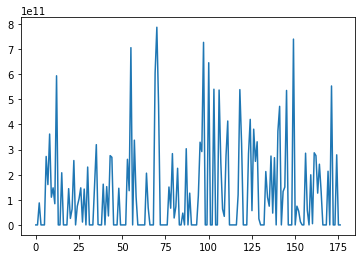

In [124]:
pd.DataFrame(log_detail)[1].plot()

<AxesSubplot:>

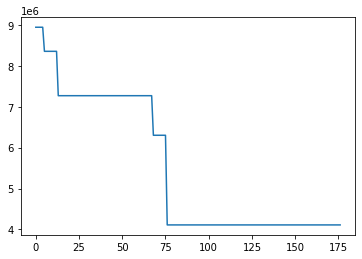

In [125]:
pd.DataFrame(log)[1].plot()

In [126]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 20
# crossover rate
r_cross = 0.6
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(objective, mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')

856899316550


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 11882161
>best! 0, 7956670
>best! 0, 7306706


  1%|          | 2/200 [00:05<09:38,  2.92s/it]

>best! 2, 4476989


 52%|█████▏    | 103/200 [05:02<04:44,  2.94s/it]

stop
Done!
CPU times: user 5min 2s, sys: 70 ms, total: 5min 2s
Wall time: 5min 2s


<AxesSubplot:>

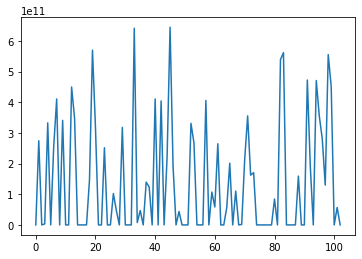

In [127]:
pd.DataFrame(log_detail)[1].plot()

<AxesSubplot:>

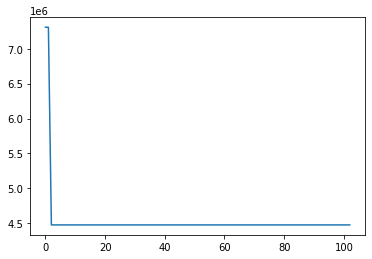

In [128]:
pd.DataFrame(log)[1].plot()

In [ ]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 40
# crossover rate
r_cross = 0.6
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(objective, mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')

In [116]:
dit['K04033', '2021-05-13']
dit['K04031', '2021-05-24']
dit['051718', '2021-05-30']
dit['S00341', '2021-03-10']
dit['052996', '2021-02-18']
dit['K04101', '2021-05-30']

15

In [117]:
i = 'K04101'
t = '2021-05-30'
u = dit[i, t] - sum(round(xijt[i, j, t]*dit[i, t] )for j in J)
u

-26

In [118]:
solution_second = dict()
xijt = decode(mijt, xijt)
for i in I:
    for j in J:
        for t in T:
            solution_second[i, j, t] = round(best[i, j, t]*dit[i, t])

sol = pd.DataFrame.from_dict(solution_second, orient='index')
#sol.to_csv('GA_solution.csv')
sol[sol[0]>0]

,0
"(K04031, 409, 2021-05-24)",88
"(K04031, 425, 2021-05-24)",72
"(K04031, 426, 2021-05-24)",83
"(K04031, 435, 2021-05-24)",95
"(K04031, 440, 2021-05-24)",79
"(052996, 410, 2021-05-30)",1
"(052996, 421, 2021-05-30)",1
"(S00271, 425, 2021-05-31)",43
"(K04033, 404, 2021-05-13)",33
"(K04033, 422, 2021-05-13)",142


In [107]:
for i in I:
    print(dit['K04033', '2021-05-24'])

0
0
0
0
0
0
0
0


In [105]:
for j in J:
    print(xijt['052996',j,'2021-02-18'])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [315]:
from mip import Model, xsum, minimize, BINARY, INTEGER



# variables
m = Model("Unist_optimization")
xijt = {
    (i, j, t): m.add_var(var_type=INTEGER, name="x_%s,%s,%s" % (i, j, t))
    for i in I for j in J for t in T
}
uit = {
    (i, t): m.add_var(var_type=INTEGER, name="u_%s,%s" % (i, t))
    for i in I for t in T
}

# objective
m.objective = minimize(
    xsum(uit[i, t]*cit[i, t]*pit[i, t] for i in I for t in T)
    )

# constraint
# Constraint 1:-
for i in I:
    for t in T:
        m += (uit[i, t] + xsum(xijt[i, j, t] for j in J) ==  dit[i, t])

# Constraint 2:-
for j in J:
    for t in T:
        m += (xsum(mijt[i, j, t]*xijt[i, j, t] for i in I) <=  600)

# Constraint 3, 4:-
for i in I:
    for j in J:
        for t in T:
            m += (xijt[i, j, t] >= 0)

for i in I:
    for t in T:
        m += (uit[i, t] >= 0)

# Constraint 5
all_set = set()
for i in I:
    for j in J:
        for t in T:
            if (i, j, t) not in ijt_set:
                m += (xijt[i, j, t] == 0)

print(m.optimize())

solution = []
for i in I:
    for j in J:
        for t in T:
            solution.append([xijt[i, j, t].name, xijt[i, j, t].x])
            solution.append([uit[i, t].name, uit[i, t].x])

solution = pd.DataFrame(
    solution,
    columns=['variable', 'solution'])
solution.sort_values(['variable', 'solution'], inplace=True)
solution.to_csv('solution.csv', index=False)
# %%
m.objective_value
# %%# %%

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 5 (-3137) rows, 7 (-1505) columns and 13 (-4902) elements
Clp1000I sum of infeasibilities 4.40252e-11 - average 8.80505e-12, 2 fixed columns
Coin0506I Presolve 4 (-1) rows, 4 (-3) columns and 8 (-5) elements
Clp0006I 0  Obj 0
Clp0000I Optimal - objective value 0
Clp0000I Optimal - objective value 0
Coin0511I After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 0
Clp0000I Optimal - objective value 0
Clp0000I Optimal - objective value 0
Clp0000I Optimal - objective value 0
Coin0511I After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 0 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc3007W No integer variables -

0.0

In [316]:
# solution.csv 파일로 저장됨

solution = pd.read_csv('solution.csv')
solution[solution['solution']>0].drop_duplicates()

,variable,solution
1040,"u_K04101,2021-05-30",15.0
1240,"u_S00271,2021-05-31",150.0
1260,"u_S00341,2021-02-10",370.0
1300,"u_S00341,2021-03-10",370.0
1320,"u_S00341,2021-04-10",370.0
1340,"u_S00341,2021-05-10",268.0
1609,"x_051718,439,2021-05-30",19.0
1693,"x_052996,421,2021-02-18",2.0
1699,"x_052996,421,2021-05-30",2.0
1832,"x_066157,408,2021-05-13",130.0


In [323]:
xijt_opt = {}
for i in I:
    for j in J:
        for t in T:
            xijt_opt[i, j, t] = xijt[i, j, t].x


In [324]:
objective(decode(mijt, xijt_opt))

18290367

In [318]:
uit = {}
xijt = constraint_check(xijt)
for i in I:
    for t in T:
        u = dit[i, t] - sum(xijt_opt[i, j, t] for j in J)
        if u >= 0:
            uit[i, t] = u
        else:
            uit[i, t] = abs(u)*1000
objective = sum(uit[i, t]*cit[i, t]*pit[i, t] for i in I for t in T)
objective

TypeError: type LinExpr doesn't define __round__ method

In [98]:
xijt_opt

{('052996', 404, '2021-02-10'): 0.0,
 ('052996', 404, '2021-02-18'): 0.0,
 ('052996', 404, '2021-03-10'): 0.0,
 ('052996', 404, '2021-04-10'): 0.0,
 ('052996', 404, '2021-05-10'): 0.0,
 ('052996', 404, '2021-05-13'): 0.0,
 ('052996', 404, '2021-05-24'): 0.0,
 ('052996', 404, '2021-05-30'): 0.0,
 ('052996', 404, '2021-05-31'): 0.0,
 ('052996', 405, '2021-02-10'): 0.0,
 ('052996', 405, '2021-02-18'): 0.0,
 ('052996', 405, '2021-03-10'): 0.0,
 ('052996', 405, '2021-04-10'): 0.0,
 ('052996', 405, '2021-05-10'): 0.0,
 ('052996', 405, '2021-05-13'): 0.0,
 ('052996', 405, '2021-05-24'): 0.0,
 ('052996', 405, '2021-05-30'): 0.0,
 ('052996', 405, '2021-05-31'): 0.0,
 ('052996', 407, '2021-02-10'): 0.0,
 ('052996', 407, '2021-02-18'): 0.0,
 ('052996', 407, '2021-03-10'): 0.0,
 ('052996', 407, '2021-04-10'): 0.0,
 ('052996', 407, '2021-05-10'): 0.0,
 ('052996', 407, '2021-05-13'): 0.0,
 ('052996', 407, '2021-05-24'): 0.0,
 ('052996', 407, '2021-05-30'): 0.0,
 ('052996', 407, '2021-05-31'): 0.0,
 